# Phase Space Plot

In [1]:
import numpy as np
import nolds
import scipy.io
import mne
import pandas as pd
import seaborn as sns
import pyqtgraph as pg
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import antropy as ent
from attractors import Attractor
from antropy import higuchi_fd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.result import RQAResult
from pyrqa.opencl import OpenCL
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.image_generator import ImageGenerator
import numpy as np
import matplotlib.pyplot as plt
from antropy import higuchi_fd

/home/vincent/miniconda3/lib/python3.10/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


# False Nearest Neighbors

Channel: Fp1
Embedding Dimension 1: Fraction of FNN = 0.5161
Embedding Dimension 2: Fraction of FNN = 0.0000
Embedding Dimension 3: Fraction of FNN = 0.0000
Embedding Dimension 4: Fraction of FNN = 0.0000
Embedding Dimension 5: Fraction of FNN = 0.0000
Embedding Dimension 6: Fraction of FNN = 0.0000
Embedding Dimension 7: Fraction of FNN = 0.0000
Embedding Dimension 8: Fraction of FNN = 0.0000
Embedding Dimension 9: Fraction of FNN = 0.0000
Embedding Dimension 10: Fraction of FNN = 0.0000
Embedding Dimension 11: Fraction of FNN = 0.0000
Embedding Dimension 12: Fraction of FNN = 0.0000
Embedding Dimension 13: Fraction of FNN = 0.0000
Embedding Dimension 14: Fraction of FNN = 0.0000
Embedding Dimension 15: Fraction of FNN = 0.0000
Embedding Dimension 16: Fraction of FNN = 0.0000
Embedding Dimension 17: Fraction of FNN = 0.0000
Embedding Dimension 18: Fraction of FNN = 0.0000
Embedding Dimension 19: Fraction of FNN = 0.0000
Embedding Dimension 20: Fraction of FNN = 0.0000
Channel: Fpz
Emb

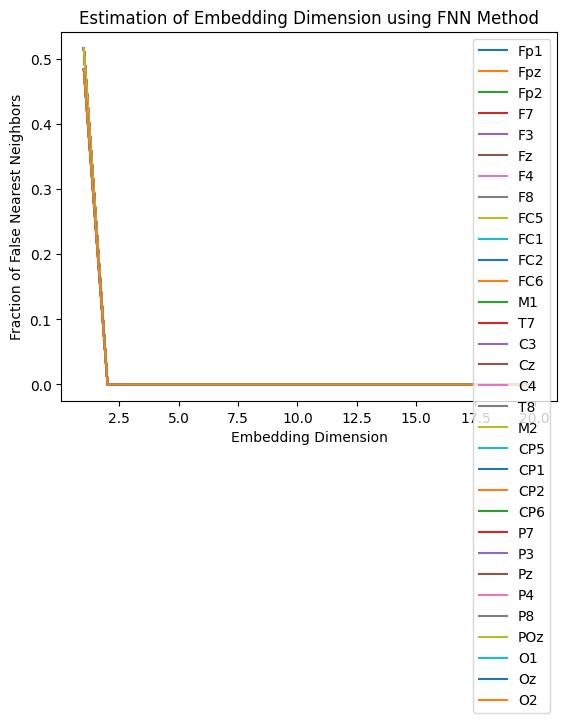

FNN data saved to /home/vincent/AAA_projects/MVCS/Neuroscience/false_nearest_neighbors.npy


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# Extract EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                    'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

max_dim = 20  # Maximum embedding dimension to consider

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i+emb_dim*delay:delay].flatten() for i in range(N - emb_dim * delay + 1)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)

    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data[:-delay])
        distances, indices = nbrs.kneighbors(emb_data[:-delay])
        neighbor_index = indices[:, 1]
        neighbor_distance = np.abs(data[neighbor_index + delay] - data[np.arange(N - d * delay) + delay])
        false_neighbors[d - 1] = np.mean((neighbor_distance / distances[:, 1]) > R)

    return false_neighbors

# Calculate FNN for different embedding dimensions for each channel
fnn_data = {}
for channel_idx, channel_name in enumerate(eeg_channel_names):
    channel_data = EEG_data[channel_idx]
    channel_data_flat = channel_data.flatten()
    fnn = false_nearest_neighbors(channel_data_flat, emb_dim=max_dim, delay=1)
    fnn_data[channel_name] = fnn
    print(f'Channel: {channel_name}')
    for dim, fnn_value in enumerate(fnn, start=1):
        print(f'Embedding Dimension {dim}: Fraction of FNN = {fnn_value:.4f}')

# Plot the FNN as a function of embedding dimension for each channel
plt.figure()
for channel_name in eeg_channel_names:
    fnn = fnn_data[channel_name]
    plt.plot(np.arange(1, max_dim+1), fnn, label=channel_name)
plt.xlabel('Embedding Dimension')
plt.ylabel('Fraction of False Nearest Neighbors')
plt.title('Estimation of Embedding Dimension using FNN Method')
plt.legend()
plt.show()

# Save the FNN data to a file
output_filename = '/home/vincent/AAA_projects/MVCS/Neuroscience/false_nearest_neighbors.npy'
np.save(output_filename, fnn_data)
print(f'FNN data saved to {output_filename}')


# 2D Phase Space Plot

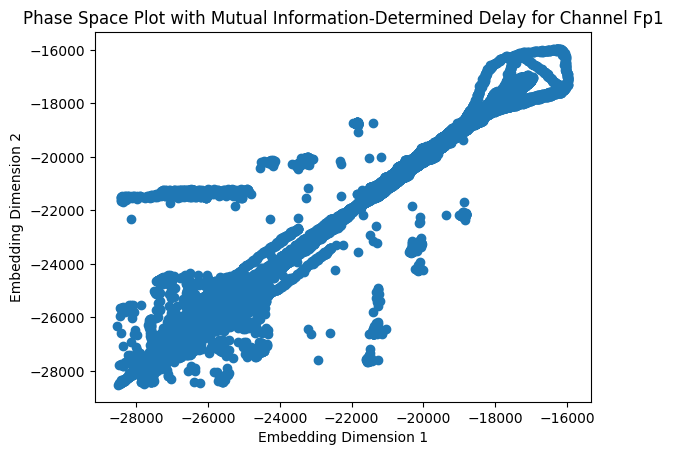

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from minepy import MINE
import multiprocessing

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE()
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    with multiprocessing.Pool() as pool:
        args_list = [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay+1)]
        mi_values = pool.map(mutual_info_worker, args_list)
    min_index = np.argmin(mi_values)
    return min_index + 1

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    embedded_data = np.zeros((N - (emb_dim - 1) * delay, emb_dim))
    for i in range(N - (emb_dim - 1) * delay):
        embedded_data[i] = [data[i + j * delay] for j in range(emb_dim)]
    return embedded_data

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# Adjust the list to match your data's channels (this list contains 32 channels as you mentioned before)
eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Choose the channel to use for the phase space plot
selected_channel = 'Fp1'

# Get the index of the selected channel
channel_index = eeg_channels.index(selected_channel)

# Extract the data for the selected channel
channel_data = EEG_data[:, channel_index]

# Determine optimal delay using mutual information with subsampling
optimal_delay = determine_delay(channel_data, subsample_factor=50)  # Adjust subsample_factor as needed

# Embedding dimension
emb_dim = 2

# Perform delay embedding
embedded_channel_data = delay_embedding(channel_data, emb_dim=emb_dim, delay=optimal_delay)

# Save the embedded data
np.save('/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/2dembedded_channel_data.npy', embedded_channel_data)

# Create 2D scatter plot with black background
plt.figure(figsize=(8, 6), facecolor='black')
plt.scatter(embedded_channel_data[:, 0], embedded_channel_data[:, 1], color='red', s=0.5)
plt.title(f'Phase Space Plot with Mutual Information-Determined Delay for Channel {selected_channel}', color='white')
plt.xlabel('Embedding Dimension 1', color='grey')
plt.ylabel('Embedding Dimension 2', color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['right'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['top'].set_color('grey')
plt.show()

# 3D Phase Space Plot

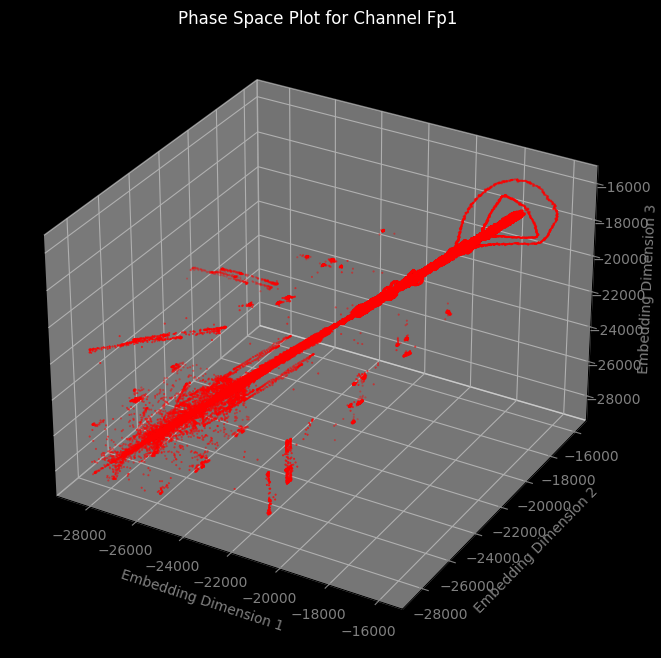

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from minepy import MINE
import multiprocessing

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE()
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    with multiprocessing.Pool() as pool:
        args_list = [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay+1)]
        mi_values = pool.map(mutual_info_worker, args_list)
    min_index = np.argmin(mi_values)
    return min_index + 1

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    embedded_data = np.zeros((N - (emb_dim - 1) * delay, emb_dim))
    for i in range(N - (emb_dim - 1) * delay):
        embedded_data[i] = [data[i + j * delay] for j in range(emb_dim)]
    return embedded_data

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# Normalize the data
channel_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)

# Choose the channel to use for the phase space plot
selected_channel = 'Fp1'

# Get the index of the selected channel
channel_index = eeg_channels.index(selected_channel)

# Extract the data for the selected channel
channel_data = EEG_data[:, channel_index]

# Determine optimal delay using mutual information with subsampling
optimal_delay = determine_delay(channel_data, subsample_factor=50)  # Adjust subsample_factor as needed

# Embedding dimension
emb_dim = 3

# Perform delay embedding
embedded_channel_data = delay_embedding(channel_data, emb_dim=emb_dim, delay=optimal_delay)

# Save the embedded data
np.save('/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/3dembedded_channel_data.npy', embedded_channel_data)

# Create 3D scatter plot with black background
fig = plt.figure(figsize=(10,8), facecolor='black')
ax = fig.add_subplot(111, projection='3d', frame_on=False)
ax.scatter(embedded_channel_data[:, 0], embedded_channel_data[:, 1], embedded_channel_data[:, 2], color='red', s=0.2)
ax.set_facecolor('black')
ax.set_title(f'Phase Space Plot for Channel {selected_channel}', color='white')
ax.set_xlabel('Embedding Dimension 1', color='grey')
ax.set_ylabel('Embedding Dimension 2', color='grey')
ax.set_zlabel('Embedding Dimension 3', color='grey')
ax.spines['left'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['top'].set_color('grey')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax.zaxis.label.set_color('grey')
ax.tick_params(axis='both', colors='grey')

plt.show()